<a href="https://colab.research.google.com/github/Deeksha-P/Adaptive-gradient-descent-without-descent/blob/master/ML_Project_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/ymalitsky/adaptive_GD.git

Cloning into 'adaptive_GD'...
remote: Enumerating objects: 126, done.
remote: Total 126 (delta 0), reused 0 (delta 0), pack-reused 126
Receiving objects: 100% (126/126), 8.79 MiB | 7.36 MiB/s, done.
Resolving deltas: 100% (57/57), done.


In [ ]:
import sys
sys.path.insert(0,'/content/adaptive_GD')

In [ ]:
%pwd

'/content/adaptive_GD'

In [ ]:
%ls

algorithms.py                             matrix_factorization.ipynb
cubic_regularization.ipynb                optimizers.py
datasets/                                 __pycache__/
img/                                      pytorch/
LICENSE*                                  README.org*
linesearch_logistic_regression_w8a.ipynb  saved_data/
logistic_regression.ipynb                 trainer.py
loss_functions.py


In [60]:
import matplotlib
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
import numpy.linalg as la
from sklearn.datasets import load_svmlight_file

In [61]:
%load optimizers.py

In [62]:
import optimizers
import loss_functions

In [63]:
from optimizers import Gd, Nesterov, Adgd, AdgdAccel, Bb, Polyak

In [64]:
from loss_functions import logistic_loss, logistic_gradient

In [65]:
sns.set(style="whitegrid", font_scale=1.2, context="talk", palette=sns.color_palette("bright"), color_codes=False)
matplotlib.rcParams['mathtext.fontset'] = 'cm'
dataset = 'cifar10'
data_path = './datasets/' + dataset
if dataset == 'cifar10':
    data_path += '.bz2'

if dataset == 'cifar10':
    it_max = 10000
else:
    it_max = 3000

def logistic_smoothness(X):
    return 0.25 * np.max(la.eigvalsh(X.T @ X / X.shape[0]))

In [68]:
data = load_svmlight_file(data_path)
X, y = data[0].toarray(), data[1]
#if (np.unique(y) == [0,1, 2,3,4,5,6,7,8,9]).all():
    # Loss functions support only labels from {0, 1}
    #y -= 1
n, d = X.shape
L = logistic_smoothness(X)
l2 = L / n if dataset == 'cifar10' else L / (10 * n) 
w0 = np.zeros(d)

def loss_func(w):
    return logistic_loss(w, X, y, l2)

def grad_func(w):
    return logistic_gradient(w, X, y, l2)

In [69]:
gd = Gd(lr=1 / L, loss_func=loss_func, grad_func=grad_func, it_max=it_max)
gd.run(w0=w0)

In [70]:
nest = Nesterov(lr=1 / L, loss_func=loss_func, grad_func=grad_func, it_max=it_max)
nest.run(w0=w0)

In [71]:
nest_str = Nesterov(lr=1 / L, strongly_convex=True, mu=l2, loss_func=loss_func, grad_func=grad_func, it_max=it_max)
nest_str.run(w0=w0)

In [72]:
adgd = Adgd(loss_func=loss_func, grad_func=grad_func, eps=0, it_max=it_max)
adgd.run(w0=w0)

/content/adaptive_GD/optimizers.py:79: RuntimeWarning: invalid value encountered in double_scalars
  L = la.norm(self.grad - self.grad_old) / la.norm(self.w - self.w_old)


In [73]:
ad_acc = AdgdAccel(loss_func=loss_func, grad_func=grad_func, it_max=it_max)
ad_acc.run(w0=w0)

/content/adaptive_GD/optimizers.py:130: RuntimeWarning: invalid value encountered in double_scalars
  L = la.norm(self.grad - self.grad_old) / la.norm(self.w - self.w_old)


In [74]:
optimizers = [gd, nest, adgd, ad_acc, nest_str]
markers = [',', 'o', '*', '^', 'D', 's', '.', 'X']

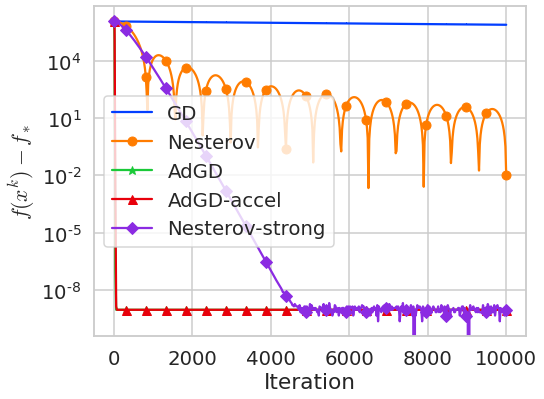

In [75]:
for opt, marker in zip(optimizers, markers):
    opt.compute_loss_on_iterates()
f_star = np.min([np.min(opt.losses) for opt in optimizers])

plt.figure(figsize=(8, 6))
labels = ['GD', 'Nesterov', 'AdGD', 'AdGD-accel', 'Nesterov-strong']
for opt, marker, label in zip(optimizers, markers + ['.', 'X'], labels):
    opt.plot_losses(marker=marker, f_star=f_star, label=label)
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel(r'$f(x^k) - f_*$')
plt.legend()
plt.tight_layout()
plt.show()

/content/adaptive_GD/optimizers.py:79: RuntimeWarning: invalid value encountered in double_scalars
  L = la.norm(self.grad - self.grad_old) / la.norm(self.w - self.w_old)


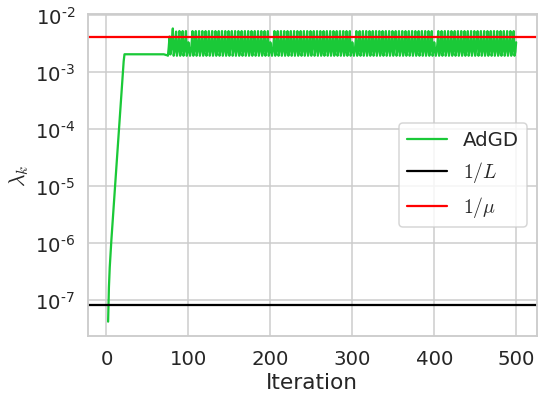

In [76]:
adgd = Adgd(loss_func=loss_func, grad_func=grad_func, eps=0, it_max=500)
adgd.run(w0=w0)
plt.figure(figsize=(8, 6))
my_green = sns.color_palette('bright')[2]
plt.plot(adgd.its[2:], adgd.lrs[2:], label='AdGD', color=my_green)
plt.axhline(y=1 / L, color='black', label='$1/L$')
plt.axhline(y=1 / l2, color='red', label='$1/\mu$')
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('$\lambda_k$')
plt.legend()
plt.tight_layout()
plt.show()

In [77]:
bb1 = Bb(loss_func=loss_func, grad_func=grad_func, option='1', it_max=2000)
bb1.run(w0=w0)

/content/adaptive_GD/optimizers.py:237: RuntimeWarning: invalid value encountered in double_scalars
  L = (self.w-self.w_old) @ (self.grad-self.grad_old) / la.norm(self.w-self.w_old)**2


In [78]:
bb2 = Bb(loss_func=loss_func, grad_func=grad_func, option='2', it_max=2000)
bb2.run(w0=w0)

/content/adaptive_GD/optimizers.py:239: RuntimeWarning: invalid value encountered in double_scalars
  L = la.norm(self.grad-self.grad_old)**2 / ((self.grad-self.grad_old) @ (self.w-self.w_old))


In [ ]:
pol = Polyak(loss_func=loss_func, grad_func=grad_func, f_opt=f_star, it_max=it_max)
pol.run(w0=w0)
pol.compute_loss_on_iterates()

In [ ]:
optimizers = [bb1, bb2, adgd, pol]
markers = [',', 'o', '*', '^', 'D', 's', '.', 'X']

In [ ]:
for opt, marker in zip(optimizers, markers):
    opt.compute_loss_on_iterates()
f_star = np.min([np.min(opt.losses) for opt in optimizers])

plt.figure(figsize=(8, 6))
labels = ['BB1', 'BB2', 'AdGD']
for opt, marker, label in zip(optimizers, markers, labels):
    opt.plot_losses(marker=marker, f_star=f_star, label=label)
plt.plot(pol.its, np.asarray(pol.losses) - f_star, marker='^', label='Polyak', color='brown', markevery=len(pol.losses)//20)
plt.yscale('log')
plt.xlabel('# matrix-vector multiplications')
plt.ylabel(r'$f(x^k) - f_*$')
plt.legend()
plt.tight_layout()
plt.show()